<a href="https://colab.research.google.com/github/Teuteu666/XAI/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lailaelouedeghyry","key":"4a4e0ab5e97a00ea12c2480eee5930c5"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset

 97% 369M/380M [00:05<00:00, 94.6MB/s]
100% 380M/380M [00:05<00:00, 75.7MB/s]


In [ ]:
!mkdir -p /content
!unzip -q augmented-alzheimer-mri-dataset.zip -d /content

In [ ]:

import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_dir = '/content/AugmentedAlzheimerDataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data_df = pd.concat([Fseries, Lseries], axis= 1)
data_df

,filepaths,labels
0,/content/AugmentedAlzheimerDataset/NonDemented...,NonDemented
1,/content/AugmentedAlzheimerDataset/NonDemented...,NonDemented
2,/content/AugmentedAlzheimerDataset/NonDemented...,NonDemented
3,/content/AugmentedAlzheimerDataset/NonDemented...,NonDemented
4,/content/AugmentedAlzheimerDataset/NonDemented...,NonDemented
...,...,...
33979,/content/AugmentedAlzheimerDataset/ModerateDem...,ModerateDemented
33980,/content/AugmentedAlzheimerDataset/ModerateDem...,ModerateDemented
33981,/content/AugmentedAlzheimerDataset/ModerateDem...,ModerateDemented
33982,/content/AugmentedAlzheimerDataset/ModerateDem...,ModerateDemented


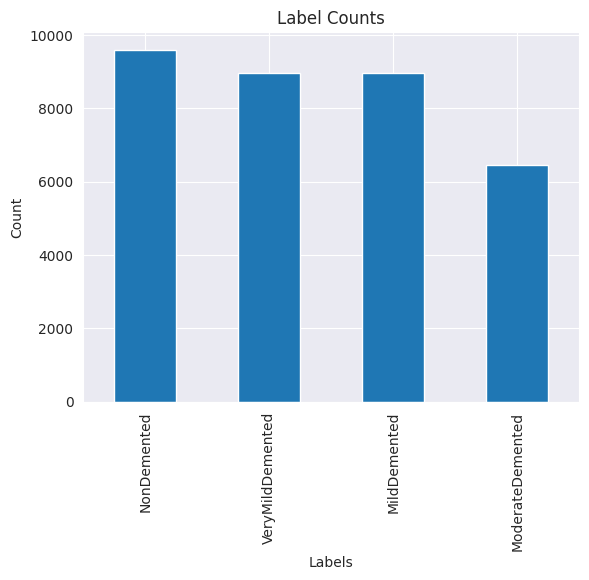

In [ ]:
import matplotlib.pyplot as plt
label_counts = data_df['labels'].value_counts()
label_counts_df = pd.DataFrame(label_counts)

# Plot the bar chart
label_counts_df.plot(kind='bar', legend=False)
plt.title('Label Counts')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
test_df,train_df = train_test_split(data_df,  train_size= 0.2, shuffle= True, random_state= 42)
print(test_df.shape)
print(train_df.shape)

(6796, 2)
(27188, 2)


In [ ]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df,rescale=1./255, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

Found 27188 validated image filenames belonging to 4 classes.


In [ ]:
test_gen = ts_gen.flow_from_dataframe( test_df,rescale=1./255, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 6796 validated image filenames belonging to 4 classes.


In [ ]:
x_train,y_train=train_gen.next()
x_test,y_test=test_gen.next()

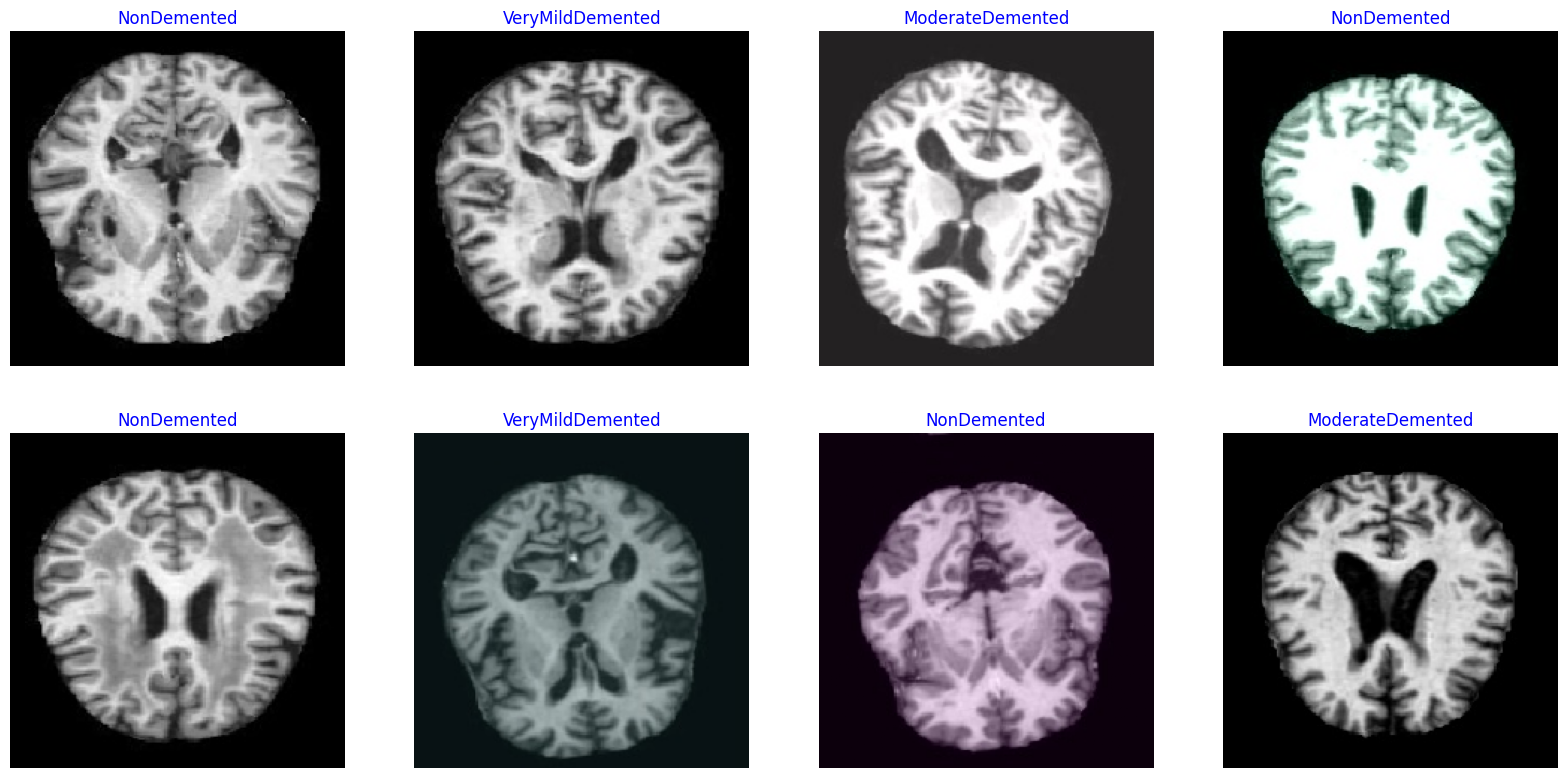

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(8):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
import keras
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras import layers, models, optimizers
from keras.preprocessing import image
import requests
from skimage.segmentation import slic
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import warnings

feature_names = train_gen.classes
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-10:]:
    layer.trainable = True


model.compile(optimizer=optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history=model.fit_generator(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=10,
    validation_data=test_gen,
    validation_steps=test_gen.samples // batch_size
)

Epoch 1/10
1699/1699 [==============================] - 144s 82ms/step - loss: 0.7787 - accuracy: 0.6380 - val_loss: 0.6840 - val_accuracy: 0.7055
Epoch 2/10
1699/1699 [==============================] - 138s 81ms/step - loss: 0.5545 - accuracy: 0.7587 - val_loss: 0.7007 - val_accuracy: 0.7423
Epoch 3/10
1699/1699 [==============================] - 155s 91ms/step - loss: 0.4087 - accuracy: 0.8351 - val_loss: 0.3487 - val_accuracy: 0.8620
Epoch 4/10
1699/1699 [==============================] - 155s 91ms/step - loss: 0.2916 - accuracy: 0.8879 - val_loss: 0.2340 - val_accuracy: 0.8980
Epoch 5/10
1699/1699 [==============================] - 155s 91ms/step - loss: 0.2109 - accuracy: 0.9226 - val_loss: 0.4542 - val_accuracy: 0.8535
Epoch 6/10
1699/1699 [==============================] - 155s 91ms/step - loss: 0.1610 - accuracy: 0.9453 - val_loss: 0.1864 - val_accuracy: 0.9304
Epoch 7/10
1699/1699 [==============================] - 156s 92ms/step - loss: 0.1209 - accuracy: 0.9589 - val_loss: 0

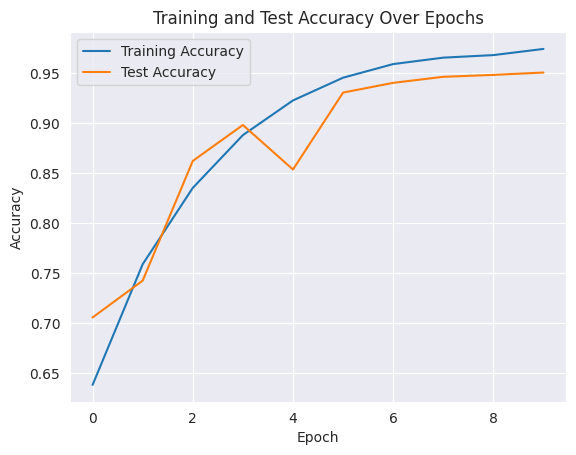

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
model.save('model_xai_2.h5')

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import Recall
from sklearn.metrics import classification_report,accuracy_score

y_true = tf.convert_to_tensor(test_gen.classes)
y_pred = tf.convert_to_tensor(y_pred)

# Create a Recall metric instance
recall_metric = Recall()

# Update the metric with your data
recall_metric.update_state(y_true, y_pred)

# Get the computed recall
recall_result = recall_metric.result().numpy()

print("Recall:", recall_result)
accuracy=accuracy_score(test_gen.classes, y_pred)
print("Accuracy: ",accuracy)

Recall: 0.97935045
Accuracy:  0.9504120070629782


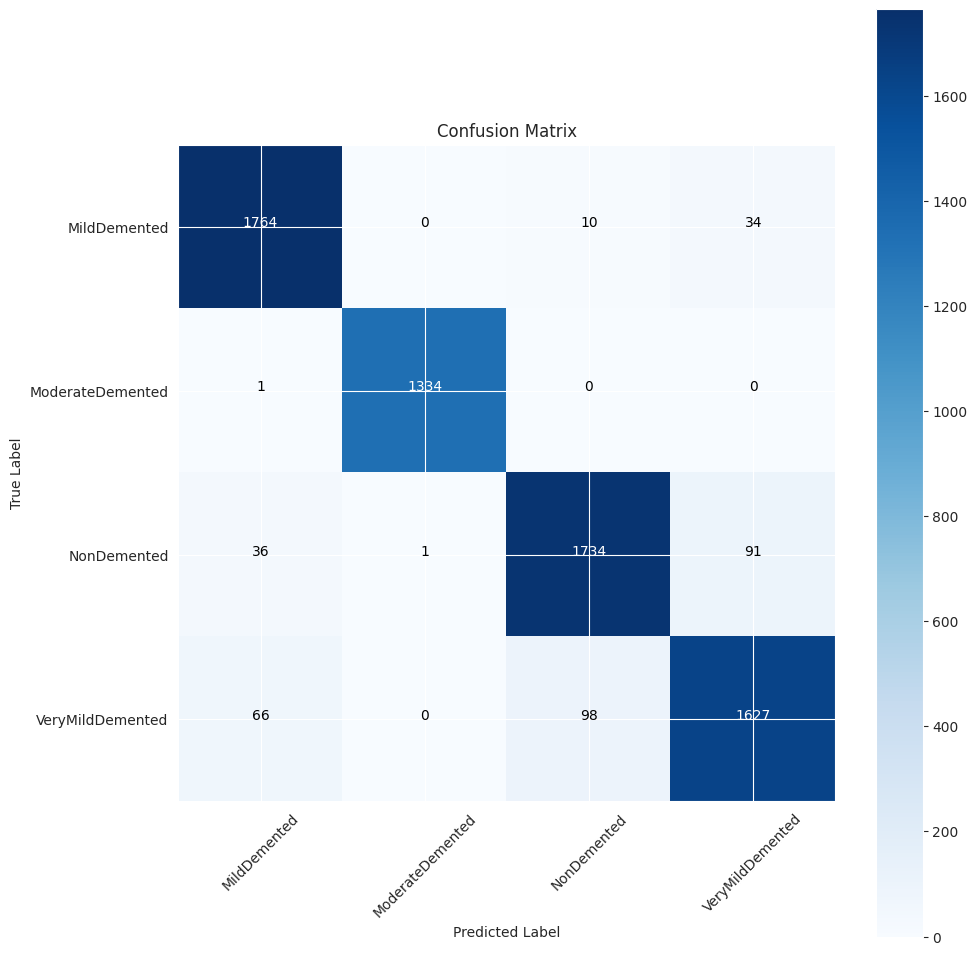

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1808
           1       1.00      1.00      1.00      1335
           2       0.94      0.93      0.94      1862
           3       0.93      0.91      0.92      1791

    accuracy                           0.95      6796
   macro avg       0.95      0.95      0.95      6796
weighted avg       0.95      0.95      0.95      6796

